<a href="https://colab.research.google.com/github/Zack4DEV/Sam_Filtered_ViT_Segmentation/blob/main/Sam_Filtered_ViT_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Note 1: Mount Google Drive

from google.colab import drive
# Mount Google Drive to access your dataset ,Be sure to create 2 folders (ViT_YOLO #+ /My files/Work/FREELANCE/DEV/Fiverr/Trees Segmentation/Sam_Filtered_ViT_Segmentation/Images) with name "/My files/Work/FREELANCE/DEV/Fiverr/Trees Segmentation/Sam_Filtered_ViT_Segmentation/Images" , inside google drive first file and folders view
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#Note 2: Import Required Libraries

import os
import fnmatch
import collections
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from transformers import ViTModel, ViTImageProcessor
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python pycocotools matplotlib onnxruntime onnx
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
!curl -L https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -o "Sam_Filtered_ViT_Segmentation/sam_vit_b.pth"




  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-awi8at69
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-awi8at69
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=74102e4e85a348fa4b86138e67ce67cb6997bd24ffd4e09ccb350fcc12edc8a1
  Stored in directory: /tmp/pip-ephem-wheel-cache-j15xbfnn/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 108.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#Note 3: File Extension Format Validation

# Dataset Base directory
base_path = "Sam_Filtered_ViT_Segmentation/Images"

if not base_path.endswith("/"):
    base_path += "/"

# Dataset Base directory Valid image file extensions
valid_extensions = ("*.jpg", "*.jpeg", "*.png", "*.webp", "*.bmp")

# Extra logging , check and validate image files in the directory
def validate_image_files(directory, extensions):
    if not os.path.exists(directory):
        raise FileNotFoundError(f"The directory {directory} does not exist.")

    matched_files = []
    for root, _, files in os.walk(directory):  # Recursively check the directory
        for pattern in extensions:
            matched_files.extend(fnmatch.filter(files, pattern))

    return matched_files

# Dataset Base directory validate and display matched image files
try:
    image_files = validate_image_files(base_path, valid_extensions)
    if image_files:
        print("Matched image files:")
        for file in image_files[:10]:  # Display the first 10 files for brevity
            print(file)
    else:
        print("No valid image files found.")
except Exception as e:
    print(f"An error occurred: {e}")

Matched image files:
sample.jpg
Tree.jpg
Tree_.jpg
DJI_20250116125602_0005_D.webp
DJI_20250116125548_0002_D.webp


In [ ]:
#Note 4: Datasets

# Dataset loaded using ImageFolder

try:
  dataset = datasets.ImageFolder(base_path)
  dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
  print("Classes detected:", dataset.classes)
except Exception as e:
  print(f"Error loading dataset: {e}")

# Base Labels directory paths
image_path = "Sam_Filtered_ViT_Segmentation/Images/Trees/"  # Path to image folder
label_path = "Sam_Filtered_ViT_Segmentation/Labels/Trees/"  # Path where YOLO labels will be stored

# Labels created directory if it doesn't exist
os.makedirs(label_path, exist_ok=True)

Classes detected: ['NotTrees', 'Trees']


In [ ]:
# Note 5: Combine SAM Masks and ViT Attention

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the SAM model
model_type = "vit_b"  # You can use "vit_h" for higher accuracy
sam_checkpoint = "Sam_Filtered_ViT_Segmentation/sam_vit_b.pth"
# Path to downloaded checkpoint

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)

mask_generator = SamAutomaticMaskGenerator(sam)

image = "Sam_Filtered_ViT_Segmentation/Images/Trees/Tree.jpg"

image = cv2.imread(image)
# Load image in BGR format
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Generate masks using SAM
masks = mask_generator.generate(image_rgb)

# Load ViT and preprocess
vit_model = ViTModel.from_pretrained("facebook/dino-vitb16",output_attentions=True)
processor = ViTImageProcessor.from_pretrained("facebook/dino-vitb16",output_attentions=True)

image_tensor = processor(images=image_rgb, return_tensors="pt")['pixel_values']

# Preprocess the image
inputs = processor(images=image_rgb, return_tensors="pt")  # Returns a dictionary with 'pixel_values'

# Forward pass and extract attention
vit_model.to(device)
# Move model to appropriate device
inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to the same device

with torch.no_grad():
    outputs = vit_model(**inputs)
    # Pass the dictionary directly
attention_map = outputs.attentions[-1].mean(dim=1).detach().cpu().numpy()  # Average across heads

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Attention map shape: (1, 197, 197)


In [ ]:
#Note 6: Filter Masks for Trees

def filter_masks_with_attention(masks, attention_map, threshold=0.5):
    filtered_masks = []
    for mask in masks:
        # Align SAM mask with ViT attention map size
        resized_mask = cv2.resize(mask['segmentation'], (attention_map.shape[1], attention_map.shape[0]))


        # Combine attention and segmentation mask
        overlap = resized_mask * (attention_map > threshold)
        if overlap.sum() > 1000:
        # Filter based on overlap area
            filtered_masks.append(mask)
            return filtered_masks

        #Used morphological operations and connected components to refine SAM masks
        kernel = np.ones((5, 5), np.uint8)
        refined_mask = cv2.morphologyEx(mask['segmentation'].astype(np.uint8), cv2.MORPH_CLOSE, kernel)

    for mask in filtered_masks:
        mask_path = f"Sam_Filtered_ViT_Segmentation/Trees/{image_path.split('/')[-1].replace('.jpg', '_mask.png')}"
        cv2.imwrite(mask_path, mask['segmentation'].astype(np.uint8) * 255)

        # Convert to YOLO polygon format
        contours, _ = cv2.findContours(mask['segmentation'].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        txt_path = mask_path.replace("_mask.png", ".txt")
        with open(txt_path, "w") as f:
            for contour in contours:
                polygon = contour.flatten().tolist()
                f.write(f"0 {' '.join(map(str, polygon))}\n")




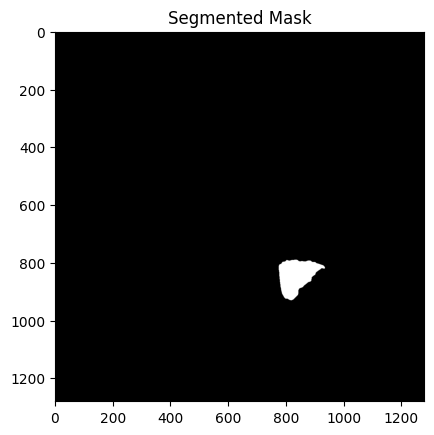

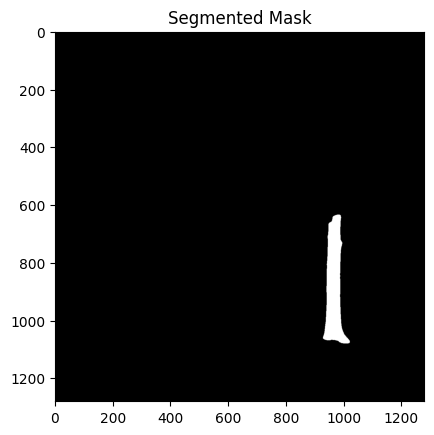

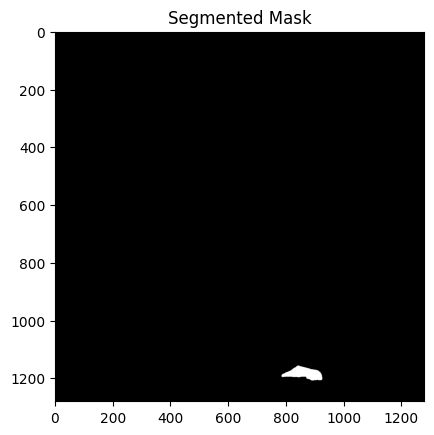

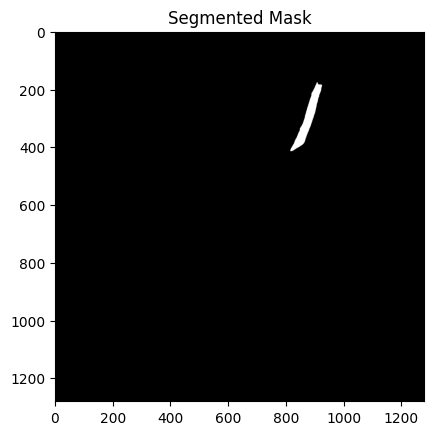

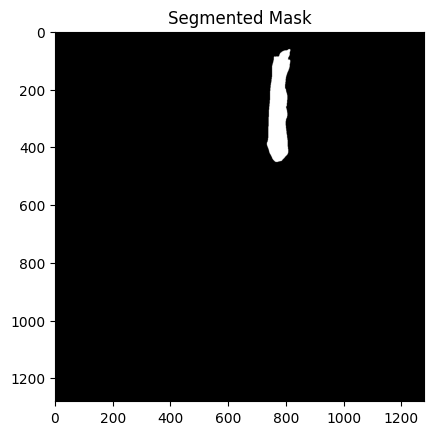

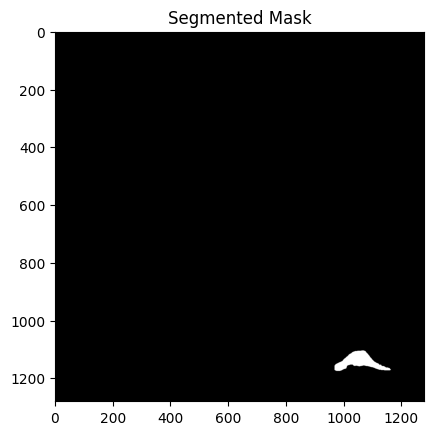

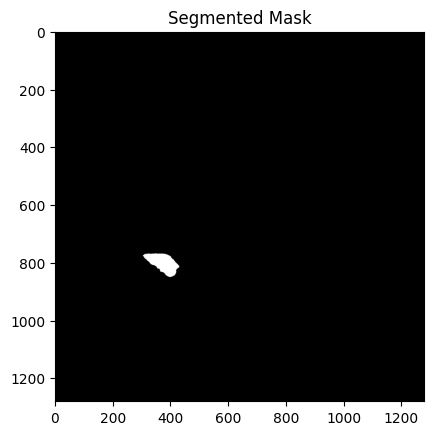

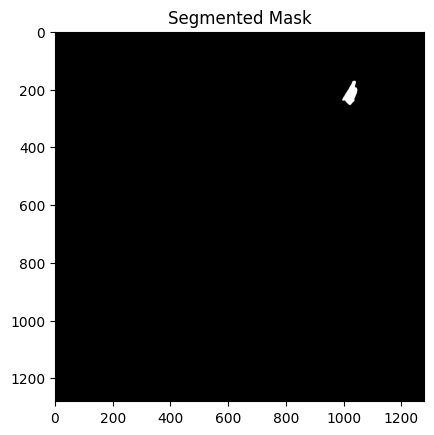

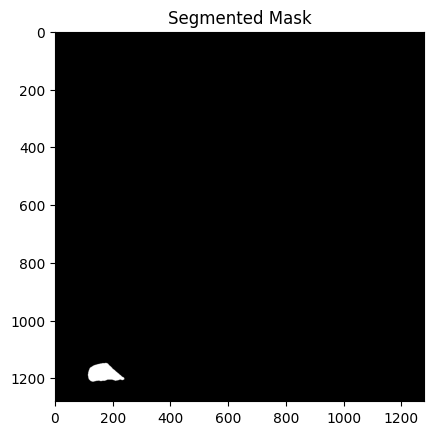

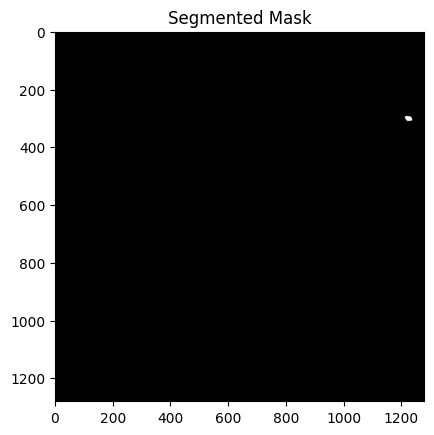

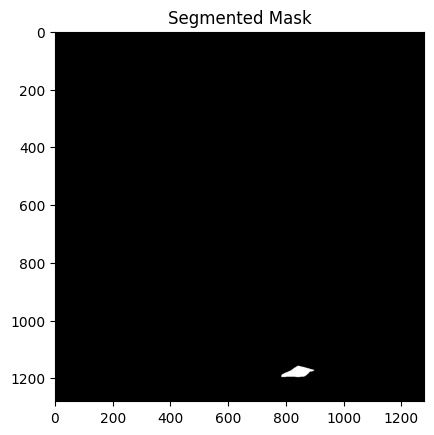

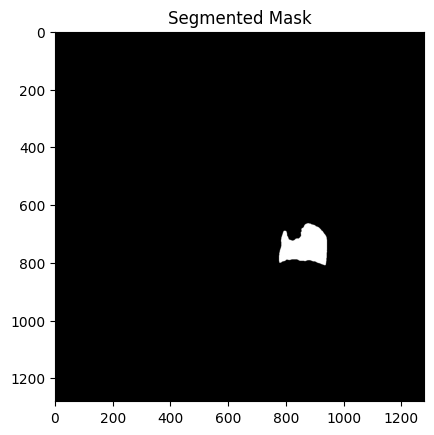

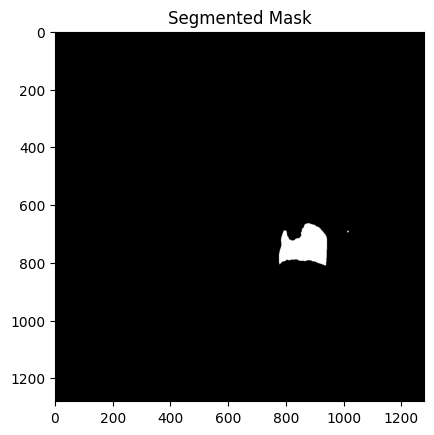

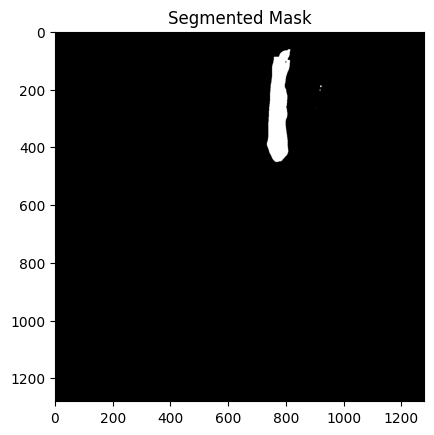

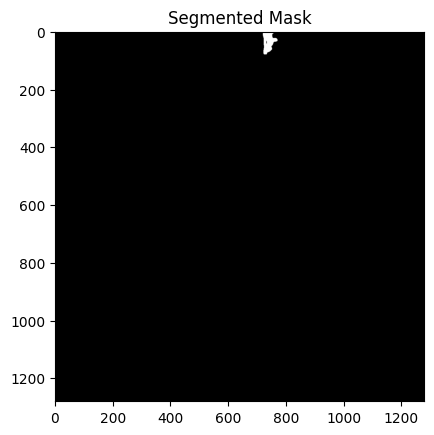

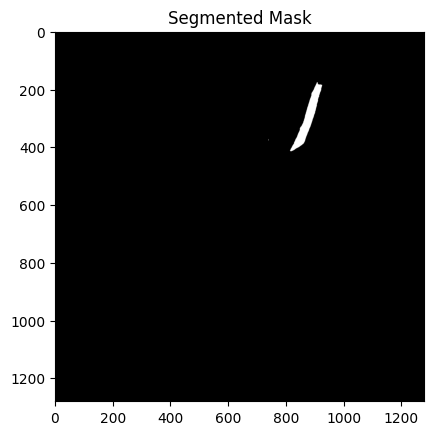

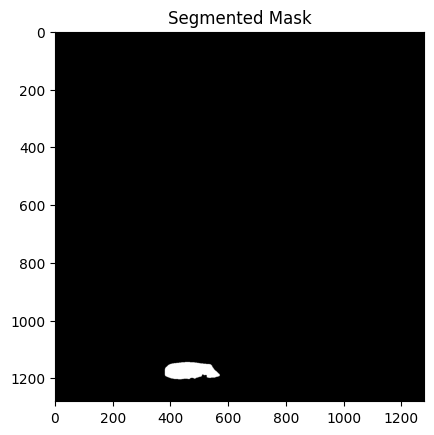

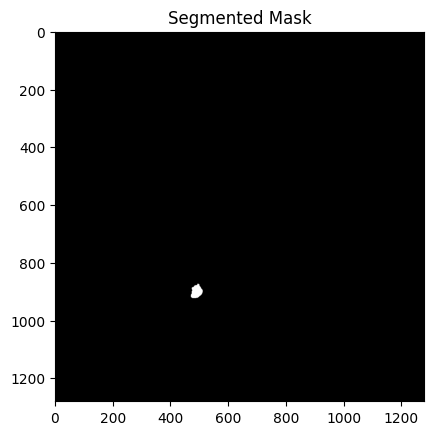

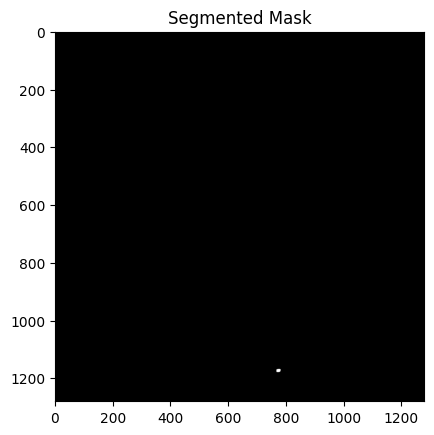

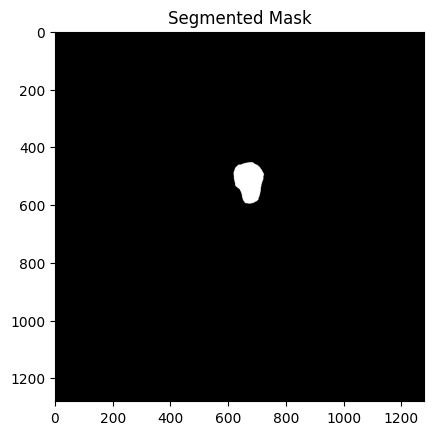

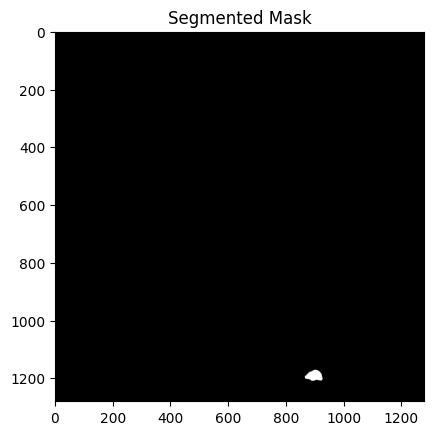

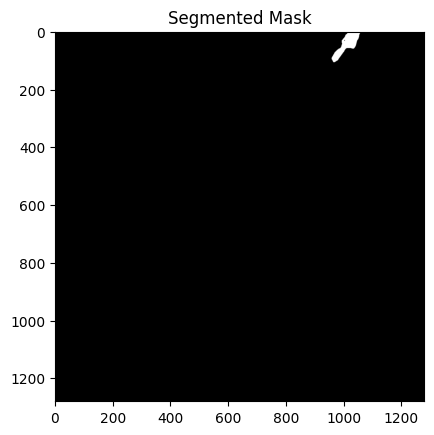

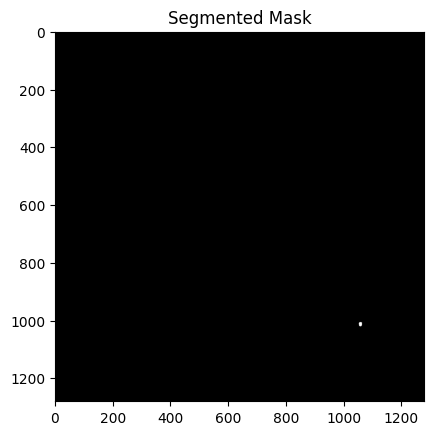

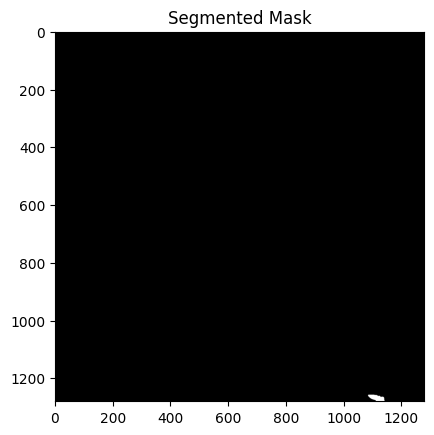

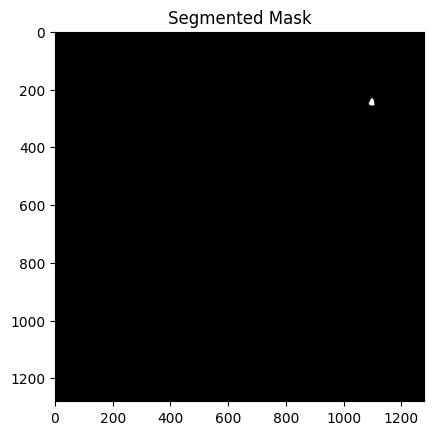

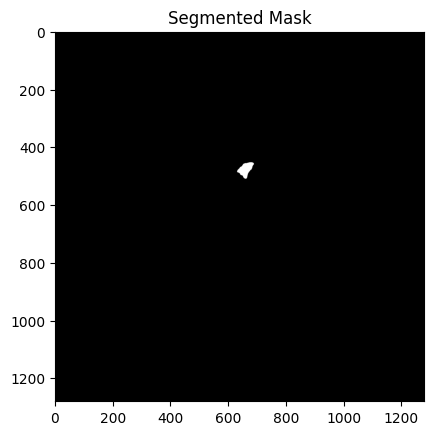

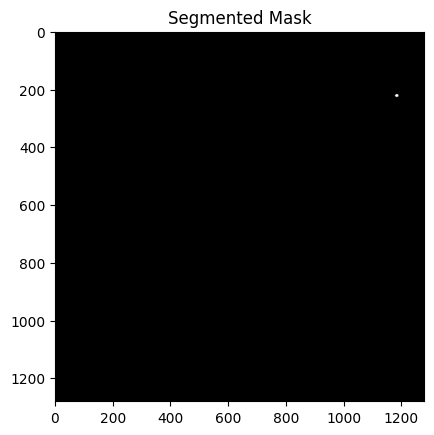

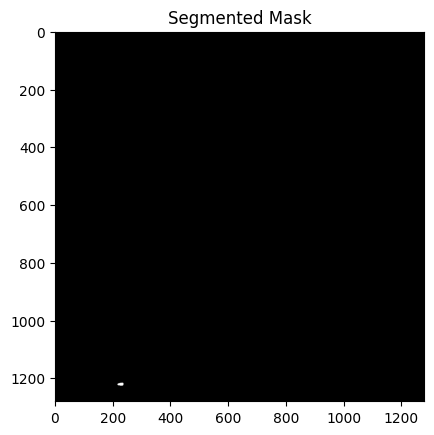

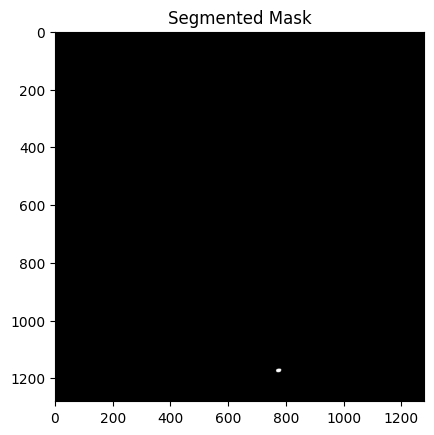

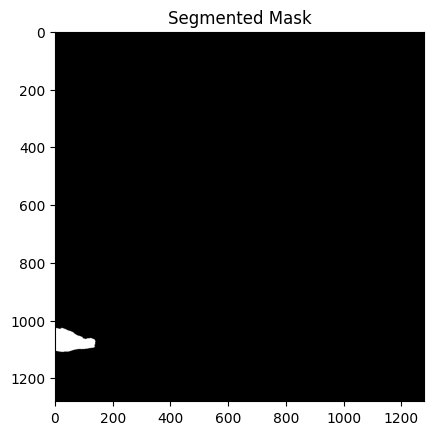

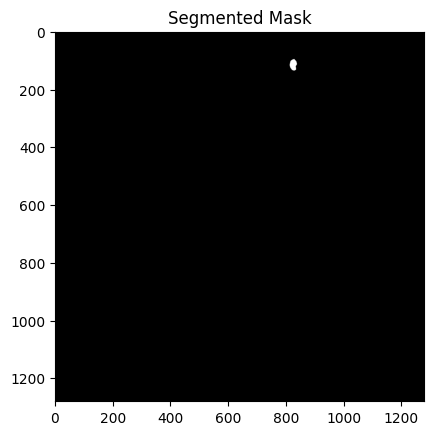

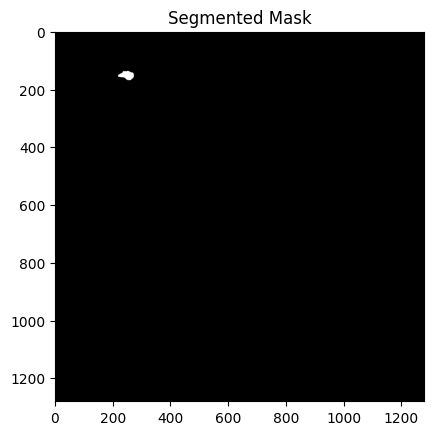

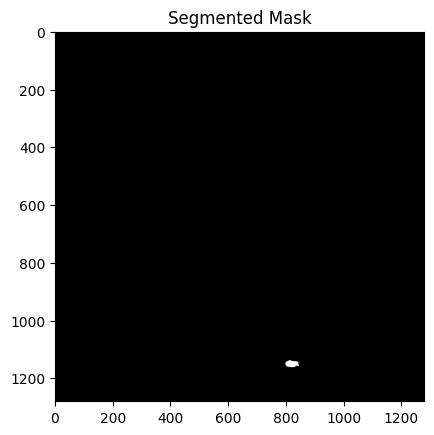

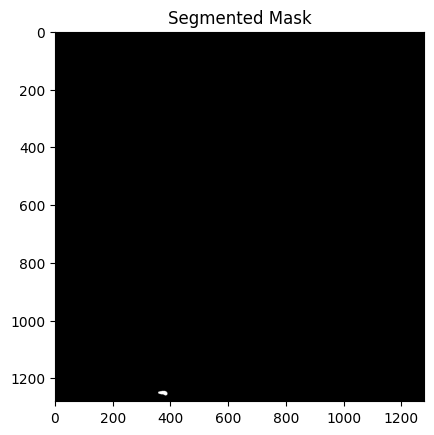

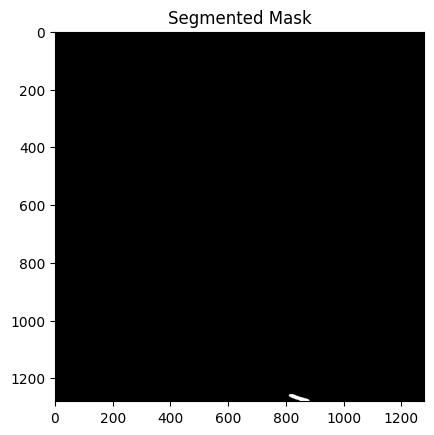

In [ ]:
#Note 7: Visualizing the masks

for mask in masks:
    plt.imshow(mask['segmentation'], cmap="gray")
    plt.title("Segmented Mask")
    plt.show()


In [ ]:
#Note 8: Train YOLOv8 with Enhanced Dataset

!pip install ultralytics
from ultralytics import YOLO

# Load YOLOv8 segmentation model
yolo_model = YOLO("yolov8n-seg.pt")

# Define dataset YAML
data_yaml = """
train: "Sam_Filtered_ViT_Segmentation/Images/"
val: "Sam_Filtered_ViT_Segmentation/Images/"
names:
  0: Trees
"""
yaml_path = "Sam_Filtered_ViT_Segmentation/dataset.yaml"
with open(yaml_path, "w") as f:
    f.write(data_yaml)

# Train YOLOv8 segmentation
yolo_model.train(
    data=yaml_path,
    epochs=20,
    imgsz=640,
    project="Sam_Filtered_ViT_Segmentation/",
    name="yolo_from_sam_filtered_vit_segmentation"
)

# Save trained model
final_model_path = "Sam_Filtered_ViT_Segmentation/yolo_from_sam_Model.pt"
yolo_model.save(final_model_path)
print(f"Final YOLOv8 model saved at: {final_model_path}")




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.74M/6.74M [00:00<00:00, 169MB/s]


Ultralytics 8.3.103 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/content/drive/MyDrive/My files/Work/FREELANCE/DEV/Fiverr/Thomas - Trees Segmentation/Sam_Filtered_ViT_Segmentation/dataset.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/My files/Work/FREELANCE/DEV/Fiverr/Thomas - Trees Segmentation/Sam_Filtered_ViT_Segmentation/, name=yolo_from_sam_filtered_vit_segmentation, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_

100%|██████████| 755k/755k [00:00<00:00, 37.5MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 158MB/s]
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:260: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:265: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Co

AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/My files/Work/FREELANCE/DEV/Fiverr/Thomas - Trees Segmentation/Sam_Filtered_ViT_Segmentation/Images/NotTrees... 0 images, 5 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]

train: WARNING ⚠️ No labels found in /content/drive/MyDrive/My files/Work/FREELANCE/DEV/Fiverr/Thomas - Trees Segmentation/Sam_Filtered_ViT_Segmentation/Images/NotTrees.cache. See https://docs.ultralytics.com/datasets for dataset formatting guidance.
train: New cache created: /content/drive/MyDrive/My files/Work/FREELANCE/DEV/Fiverr/Thomas - Trees Segmentation/Sam_Filtered_ViT_Segmentation/Images/NotTrees.cache
WARNING ⚠️ No labels found in /content/drive/MyDrive/My files/Work/FREELANCE/DEV/Fiverr/Thomas - Trees Segmentation/Sam_Filtered_ViT_Segmentation/Images/NotTrees.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/My files/Work/FREELANCE/DEV/Fiverr/Thomas - Trees Segmentation/Sam_Filtered_ViT_Segmentation/Images/NotTrees.cache... 0 images, 5 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<?, ?it/s]

WARNING ⚠️ No labels found in /content/drive/MyDrive/My files/Work/FREELANCE/DEV/Fiverr/Thomas - Trees Segmentation/Sam_Filtered_ViT_Segmentation/Images/NotTrees.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


Plotting labels to /content/drive/MyDrive/My files/Work/FREELANCE/DEV/Fiverr/Thomas - Trees Segmentation/Sam_Filtered_ViT_Segmentation/yolo_from_sam_filtered_vit_segmentation/labels.jpg... 
zero-size array to reduction operation maximum which has no identity
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)


In [ ]:
#Note 9: Evaluating the performance of your segmentation model

def calculate_iou(predicted_mask, ground_truth_mask):
    intersection = torch.logical_and(predicted_mask, ground_truth_mask).sum()
    union = torch.logical_or(predicted_mask, ground_truth_mask).sum()
    iou = intersection / union
    return iou.item()

def calculate_precision(predicted_mask, ground_truth_mask):
    true_positives = torch.logical_and(predicted_mask, ground_truth_mask).sum()
    false_positives = torch.logical_and(predicted_mask, ~ground_truth_mask).sum()
    precision = true_positives / (true_positives + false_positives)
    return precision.item()

def calculate_recall(predicted_mask, ground_truth_mask):
    true_positives = torch.logical_and(predicted_mask, ground_truth_mask).sum()
    false_negatives = torch.logical_and(~predicted_mask, ground_truth_mask).sum()
    recall = true_positives / (true_positives + false_negatives)
    return recall.item()

def calculate_ap(predicted_mask, ground_truth_mask):
    # Calculate precision and recall at different thresholds
    thresholds = torch.linspace(0, 1, 100)
    precisions = []
    recalls = []
    for threshold in thresholds:
        predicted_mask_thresholded = predicted_mask > threshold
        precision = calculate_precision(predicted_mask_thresholded, ground_truth_mask)
        recall = calculate_recall(predicted_mask_thresholded, ground_truth_mask)
        precisions.append(precision)
        recalls.append(recall)

    # Interpolate precision values at different recall levels
    interpolated_precisions = []
    for recall_level in torch.linspace(0, 1, 100):
        interpolated_precision = 0
        for i in range(len(recalls) - 1):
            if recalls[i] <= recall_level <= recalls[i + 1]:
                interpolated_precision = (precisions[i + 1] - precisions[i]) / (recalls[i + 1] - recalls[i]) * (recall_level - recalls[i]) + precisions[i]
                break
        interpolated_precisions.append(interpolated_precision)

    # Calculate AP
    ap = sum(interpolated_precisions) / len(interpolated_precisions)
    return ap.item()

predicted_mask = torch.randn(256, 256) > 0.5
ground_truth_mask = torch.randn(256, 256) > 0.5

iou = calculate_iou(predicted_mask, ground_truth_mask)
precision = calculate_precision(predicted_mask, ground_truth_mask)
recall = calculate_recall(predicted_mask, ground_truth_mask)
ap = calculate_ap(predicted_mask, ground_truth_mask)

print(f"IoU: {iou:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AP: {ap:.4f}")


NameError: name 'torch' is not defined